In [1]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec
from matplotlib.patches import ConnectionPatch

from matplotlib import rc
rc('font', **{'family':'serif','sans-serif':['Computer Modern Roman'], 'size':14})
rc('text', usetex=True)

from scipy.interpolate import InterpolatedUnivariateSpline as spline
from cmcrameri import cm

import qnmfits

In [2]:
sim = qnmfits.SXS(305, ellMax=2, zero_time=(2,2))
sim_lower_lev = qnmfits.SXS(305, ellMax=2, zero_time=(2,2), lev_minus_highest=-1)

Skipping download from 'https://data.black-holes.org/catalog.json' because local file is newer
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/rhOverM_Asymptotic_GeometricUnits_CoM.h5
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev6/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev5/metadata.json
Found the following files to load from the SXS catalog:
    SXS:BBH:0305v5/Lev5/rhOverM_Asymptotic_GeometricUnits_CoM.h5


In [4]:
# Interpolate both waveforms and evaluate on a dense grid
times = np.arange(-50, 175, np.min(np.diff(sim.times)))

sim_interp_h22 = spline(sim.times, np.real(sim.h[2,2]), ext=1, k=1)(times) + \
    1j*spline(sim.times, np.imag(sim.h[2,2]), ext=1, k=3)(times)

sim_lower_lev_interp_h22 = spline(sim_lower_lev.times, np.real(sim_lower_lev.h[2,2]), ext=1, k=1)(times) + \
    1j*spline(sim_lower_lev.times, np.imag(sim_lower_lev.h[2,2]), ext=1, k=3)(times)

# Align the peaks of the waveforms
sim_lower_lev_interp_h22 = np.roll(
    sim_lower_lev_interp_h22, 
    np.argmax(abs(sim_interp_h22))-np.argmax(abs(sim_lower_lev_interp_h22))
    )

In [5]:
def inner_product_FD_phasetimemax(times, sigA, sigB):

    dt = times[1]-times[0]
    
    sigA_FD = np.fft.fft(sigA)*dt
    sigB_FD = np.fft.fft(sigB)*dt
    
    delta_t = dt*np.argmax(np.abs(np.fft.ifft(sigA_FD * np.conjugate(sigB_FD))))
    
    ans = np.fft.ifft(sigA_FD*np.conj(sigB_FD))/dt
    
    return max(abs(ans))

def mismatch_phasetimemax(times, wf_1, wf_2):
    """
    Calculates the mismatch (see, for example, arXiv:1903.08284) between two
    complex waveforms.

    Parameters
    ----------
    times : array
        The times at which the waveforms are evaluated.
        
    wf_1, wf_2 : array
        The two waveforms to calculate the mismatch between.
        
    RETURNS
    -------
    M : float
        The mismatch between the two waveforms.
    """
    
    numerator = inner_product_FD_phasetimemax(times, wf_1, wf_2)
    
    denominator = np.sqrt(
        inner_product_FD_phasetimemax(times, wf_1, wf_1)
        * inner_product_FD_phasetimemax(times, wf_2, wf_2))
    
    return 1 - (numerator/denominator)

def mismatch_phasemax(times, wf_1, wf_2):

    numerator = np.abs(np.trapz(wf_1 * np.conjugate(wf_2), x=times))
    
    denominator = np.sqrt(np.trapz(np.real(wf_1 * np.conjugate(wf_1)), x=times)
                         *np.trapz(np.real(wf_2 * np.conjugate(wf_2)), x=times))
    
    return 1 - (numerator/denominator)

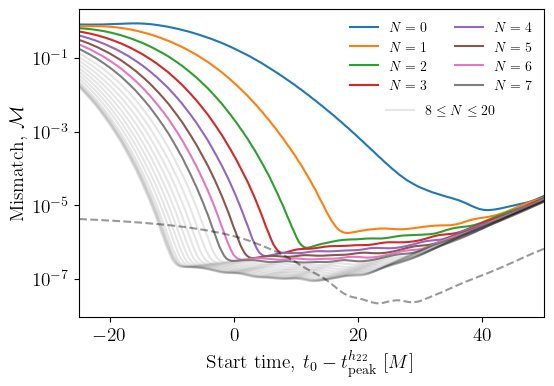

In [6]:
# The mode combinations to try
mode_list = [[(2,2,n,1) for n in range(N)] for N in range(1,22)] # [1,2,3,4,5,6,7,8,10,12,14,16,18,20]]

# The start times to use
t0_array = np.linspace(-25, 50, 200)
T = 90

# Create figure
fig, ax = plt.subplots(figsize=(6,(6/1.5)))

for modes in mode_list:
    
    n = modes[-1][-2]
    
    # Create mismatch list
    mm_list = qnmfits.mismatch_t0_array(
        times,
        sim_interp_h22,
        modes,
        sim.Mf,
        sim.chif_mag,
        t0_array, 
        T_array=90,
        spherical_modes=[(2,2)]
        )
    
    if n < 8:
        c = f'C{n}'
        label = f'$N = {n}$'
        alpha=1
        ls='-'
    else:
        c = 'k'
        label=None
        alpha=0.1
        ls='-'
    
    # Add to figure
    ax.semilogy(t0_array, mm_list, c=c, label=label, alpha=alpha, ls=ls)
    
# Calculate the mismatch with the lower level waveform
mm_list = []
    
for t0 in t0_array:
    
    # Mask to cut data between the chosen start time and T
    data_mask = (times>=t0) & (times<t0+T)
    mask_times = times[data_mask]
    
    mm_list.append(
       mismatch_phasemax(
            mask_times, 
            sim_interp_h22[data_mask], 
            sim_lower_lev_interp_h22[data_mask]
            )
        )
    
ax.semilogy(t0_array, mm_list, '--', c='k', alpha=0.4)
    
# Plot limits and labels
ax.set_xlim(t0_array[0], t0_array[-1])
ax.set_xlabel('Start time, $t_0 - t_\mathrm{peak}^{h_{22}}\ [M]$')
ax.set_ylabel('Mismatch, $\mathcal{M}$')

l1 = ax.legend(frameon=False, loc='upper right', fontsize=10, ncol=2)
ax.add_artist(l1)

ax.legend(
    [Line2D([0], [0], c='k', alpha=0.1)],
    ['$8 \leq N \leq 20$'],
    frameon=False, 
    fontsize=10,
    loc='upper right',
    bbox_to_anchor=(0.92225,0.73)
    )

fig.savefig('305_mismatch_vs_t0_updated.pdf', bbox_inches='tight') # , dpi=300, transparent=True)

In [ ]:
Mf_N_7_min_max = [sim.Mf-0.1, sim.Mf+0.35]
chif_N_7_min_max = [sim.chif_mag-0.1, sim.chif_mag+0.2]

# mm_grid_N_7 = qnmfits.mismatch_M_chi_grid(
#     sim.times,
#     sim.h[2,2],
#     modes=[(2,2,n,1) for n in range(7+1)],
#     Mf_minmax=Mf_N_7_min_max, 
#     chif_minmax=chif_N_7_min_max, 
#     t0=0,
#     res=500,
#     spherical_modes=[(2,2)]
#     )

mm_grid_N_7 = np.loadtxt('mm_grid.dat')

fig, ax = plt.subplots(figsize=(6,5))

im = ax.imshow(
    np.log10(mm_grid_N_7), 
    extent=chif_N_7_min_max+Mf_N_7_min_max,
    aspect='auto',
    origin='lower',
    interpolation='none',
    cmap='gist_heat_r'
    )

# Indicate true values
ax.axhline(sim.Mf, color='white', alpha=0.3)
ax.axvline(sim.chif_mag, color='white', alpha=0.3)

# Plot the mismatch minima from different numbers of overtones
for i, N in enumerate([1,2,3,4,5,6,7,8]):
    epsilon, Mf_bestfit, chif_bestfit = qnmfits.calculate_epsilon(
        sim.times, 
        sim.h[2,2], 
        modes=[(2,2,n,1) for n in range(N)], 
        Mf=sim.Mf, 
        chif=sim.chif_mag, 
        t0=0, 
        T=100, 
        spherical_modes=[(2,2)]
        )
    if (i==5) or (i==6):
        pass
    else:
        ax.scatter(
            chif_bestfit, 
            Mf_bestfit, 
            marker='x', 
            s=70, 
            zorder=10,
            color=f'C{i}', 
            label=f'$N={N-1}$'
            )

# Colour bar
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('Log mismatch, $\mathrm{log}_{10}\ \mathcal{M}$')

ax.text(0.75, 0.135, '$t_0 = t_{\mathrm{peak}}^{h_{22}}$', fontdict={'c':'white'}, transform=ax.transAxes)
ax.text(0.75, 0.055, '$N=7$', fontdict={'c':'white'}, transform=ax.transAxes)

ax.set_xlabel('Remnant spin, $\chi_f$')
ax.set_ylabel('Remnant mass, $M_f\ [M]$')

ax.legend(fontsize=14, borderpad=0.4, handletextpad=0.5, borderaxespad=0.7, handlelength=1.3, loc='upper left', bbox_to_anchor=(0.017, 0.99))

fig.savefig('305_epsilon_grid_updated.pdf', bbox_inches='tight', dpi=300, transparent=True)

In [7]:
N_list = list(range(21))
fit_times = [-5, 0, 5]
epsilon_dict = {fit_time: [] for fit_time in fit_times}

for fit_time in fit_times:

    for N in N_list:

        modes = [(2,2,n,1) for n in range(N+1)]

        epsilon, Mf_bestfit, chif_bestfit = qnmfits.calculate_epsilon(
                sim.times, 
                sim.h[2,2], 
                modes=modes, 
                Mf=sim.Mf, 
                chif=sim.chif_mag, 
                t0=fit_time, 
                T=100, 
                spherical_modes=[(2,2)]
                )

        epsilon_dict[fit_time].append(epsilon)

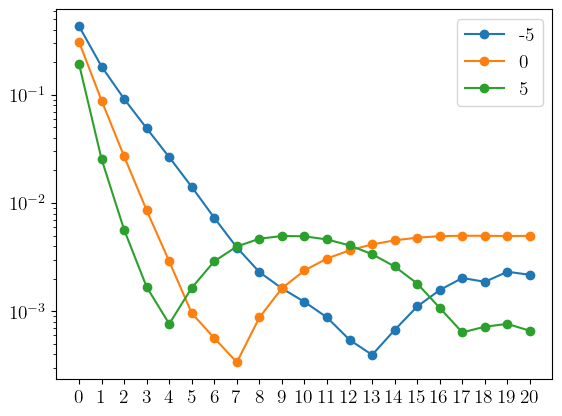

In [8]:
fig, ax = plt.subplots()

for fit_time, epsilon_list in epsilon_dict.items():

    ax.plot(N_list, epsilon_list, marker='o', label=fit_time)

ax.set_yscale('log')
ax.set_xticks(N_list)

ax.legend()

In [59]:
Ns = [13, 7, 4]
amp_dict = {}

for N, fit_time in zip(Ns, fit_times):
    
    best_fit = qnmfits.ringdown_fit(
        sim.times, 
        sim.h[2,2], 
        [(2,2,n,1) for n in range(N+1)],
        sim.Mf,
        sim.chif_mag,
        fit_time
        )
    
    C = best_fit['C']
    
    rescaled_C = []
    for n in range(N+1):
        tau = -1/np.imag(qnmfits.qnm.omega(2,2,n,1,chif=sim.chif_mag))
        rescaled_C.append(abs(C)[n]*np.exp(fit_time/tau))
        
    amp_dict[fit_time] = [best_fit['mode_labels'], abs(C), rescaled_C]

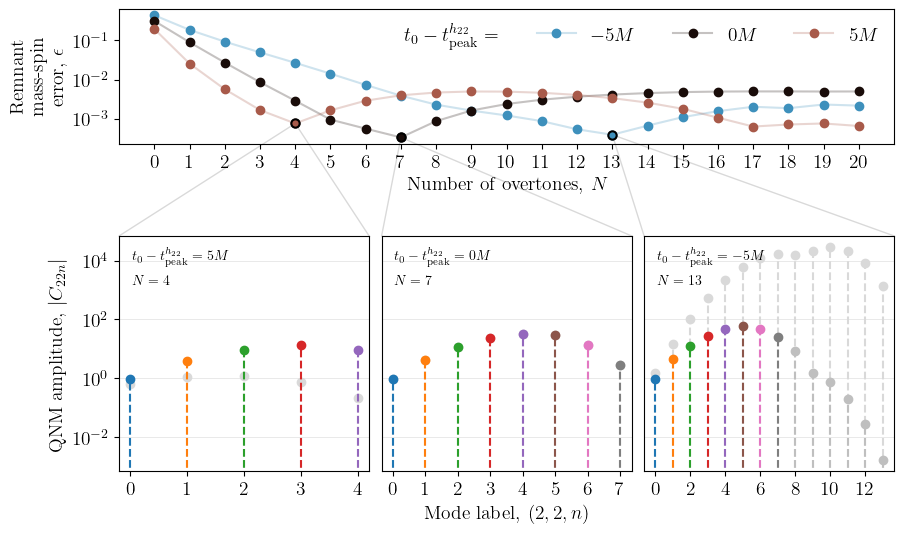

In [73]:
fig = plt.figure(figsize=(10, 6))

main_grid = fig.add_gridspec(2, 1, height_ratios=[1,1.75], hspace=0.5)

ax1 = fig.add_subplot(main_grid[0, 0])

sub_grid = main_grid[1, 0].subgridspec(1, 3, wspace=0.05)
ax2, ax3, ax4 = sub_grid.subplots() 

ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')

ax3.set_yticks([])
ax4.set_yticks([])

ax1.set_xlabel('Number of overtones, $N$')
ax1.set_ylabel('Remnant \nmass-spin \nerror, $\epsilon$')

ax2.set_ylabel('QNM amplitude, $|C_{22 n}|$')

ax3.set_xlabel('Mode label, $(2,2,n)$')

# --------------------------------------

for i, (fit_time, epsilon_list) in enumerate(epsilon_dict.items()):
    
    c = cm.berlin(0.5+((i-1)/3)) # f'C{i}'
    line_c = list(c)[:3] + [0.25]

    ax1.plot(N_list, epsilon_list, c=line_c, marker='o', label=f'${fit_time}M$', markeredgecolor=c, markerfacecolor=c)
    
ax1.set_xticks(N_list)

ax1.text(0.49, 0.9, '$t_0 - t_\mathrm{peak}^{h_{22}} = $', horizontalalignment='right',verticalalignment='top', transform=ax1.transAxes)
ax1.legend(ncol=3, frameon=False)

# -------------

for i in range(len(amp_dict)):
    
    ax = [ax4, ax3, ax2][i]
    fit_time = fit_times[i]

    mode_labels = amp_dict[fit_time][0]
    amps = amp_dict[fit_time][1]
    rescaled_amps = amp_dict[fit_time][2]

    x = np.arange(len(amps))
    x_shift = 0

    for i in range(len(x)):

        ls = '--'

        ax.plot(
            [x[i]-x_shift,x[i]-x_shift], [0,amps[i]], 
            color='#d9d9d9', 
            marker='o', 
            markevery=(1,2), 
            linestyle=ls
            )

        if i < 8:
            c = f'C{i}'
        else:
            c = '#bfbfbf'
        ls = '--'

        ax.plot(
            [x[i]+x_shift,x[i]+x_shift], [0,rescaled_amps[i]], 
            color=c, 
            marker='o', 
            markevery=(1,2), 
            linestyle=ls
            )

ax2.set_xticks([0,1,2,3,4])
ax3.set_xticks([0,1,2,3,4,5,6,7])
ax4.set_xticks([0,2,4,6,8,10,12])
    
ylim = ax4.get_ylim()

ax2.set_ylim(ylim)
ax3.set_ylim(ylim)

ax2.yaxis.set_minor_locator(ax1.yaxis.get_minor_locator())

grid_locs = [1e-2, 1, 1e2, 1e4]
for loc in grid_locs:
    ax2.axhline(loc, c='k', alpha=0.1, zorder=-10, lw=0.6)
    ax3.axhline(loc, c='k', alpha=0.1, zorder=-10, lw=0.6)
    ax4.axhline(loc, c='k', alpha=0.1, zorder=-10, lw=0.6)
    
for i, (fit_time, epsilon_list) in enumerate(epsilon_dict.items()):
    
    ax = [ax4, ax3, ax2][i]
    
    min_loc = np.argmin(epsilon_list[:-5])
    min_epsilon = epsilon_list[min_loc]
    min_N = N_list[min_loc]
    
    fig.add_artist(
        ConnectionPatch(
            xyA=(min_N,min_epsilon), 
            coordsA=ax1.transData, 
            xyB=(0,1), 
            coordsB=ax.transAxes,
            color='k',
            alpha=0.15,
            zorder=0.
            )
        )
    
    fig.add_artist(
        ConnectionPatch(
            xyA=(min_N,min_epsilon), 
            coordsA=ax1.transData, 
            xyB=(1,1), 
            coordsB=ax.transAxes,
            color='k',
            alpha=0.15,
            zorder=0.
            )
        )
    
    c = cm.berlin(0.5+((i-1)/3)) # f'C{i}'
    ax1.plot(min_N, min_epsilon, marker='o', c=c, markeredgecolor='k', markeredgewidth=1.5)
    
    ax.text(
        0.05, 0.91, f'$t_0 - t_\mathrm{{peak}}^{{h_{{22}}}} = {fit_time}M$', 
        horizontalalignment='left',
        verticalalignment='center', 
        transform=ax.transAxes,
        fontsize=10
        )
    
    ax.text(
        0.05, 0.81, f'$N={min_N}$', 
        horizontalalignment='left',
        verticalalignment='center', 
        transform=ax.transAxes,
        fontsize=10
        )
    
ax1.patch.set_alpha(0.)
    
fig.savefig('305_even_more_overtones.pdf', bbox_inches='tight')

In [80]:
n7_at_peak = amp_dict[0][1][7]

In [88]:
n7_at_m5M = amp_dict[-5][2][7]

In [90]:
n7_at_m5M/n7_at_peak

9.028827538568052